In [40]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [41]:
df = pd.read_csv('recomendations.csv')

In [42]:
df.head()

,Unnamed: 0,stocks,SMA42,SMA150,RSI,VAR,recomendations
0,0,"['CVCB3', 'SBSP3', 'LAME4', 'COGN3']",0.183015,0.217421,0.258782,0.564886,[[' LREN3' '3']\n [' BBDC4' '3']\n [' GOAU4' '...
1,1,"['HGTX3', 'CVCB3', 'ELET6', 'ABEV3', 'ENBR3', ...",0.467806,0.363506,0.676520,0.421233,[[' GGBR4' '2']\n [' ENGI11' '2']\n [' IRBR3' ...
2,2,"['LAME4', 'SBSP3', 'TAEE11', 'GOAU4']",0.310407,0.366342,0.386661,0.416246,[[' CMIG4' '3']\n [' BBDC4' '3']\n [' ITSA4' '...
3,3,"['FLRY3', 'EQTL3', 'VVAR3', 'MRVE3', 'LAME4', ...",0.173675,0.183636,0.202709,0.286562,[[' SULA11' '2']\n [' ENEV3' '2']\n [' ITSA4' ...
4,4,"['TIMS3', 'LREN3', 'GOLL4', 'BBDC4']",0.358413,0.368369,0.356500,0.542556,[[' BEEF3' '2']\n [' YDUQ3' '2']\n [' ELET3' '...


In [43]:
stocks = random.sample(list(df.recomendations), 1)

In [44]:
recs = []
for stock in stocks[0].split('\n'):
    recs.append(stock.split("'")[1][1:])


Creating portfolio:

In [45]:
from yahooquery import Ticker
def get_data(ticker, start = 0, end = 0, period = -1):
    stock = Ticker(ticker)
    if period == 'max':
        df = stock.history(period='max')
        
    else:
        df = stock.history(start=start, end=end)
    
    df = df.xs(ticker)
    return df

# Otimização de portfolio

Estudo da maximização do retorno por meio da escolha de um portfolio correto, baseado na Modern Portfolio Theory, de Harry Markowitz. É preciso, também, assumir que os retornos são uma distribuição normal.

A ideia é usar diversificação para atingir um portfolio com risco mínimo ou máximo retorno, dado um intervalo de confiança. 

In [46]:
data =  pd.DataFrame()
for s in recs:
    df = get_data(s+'.SA', start='2021-01-03', end='2021-07-31')
    
    close = df['close']
    close.rename(s, inplace=True)
    data = data.append(close)

In [47]:
data = data.transpose()
noa = len(recs)

rets = np.log(data/data.shift(1))

In [48]:
rets

,ENEV3,LWSA3,KLBN11,GNDI3,UGPA3,ENBR3,RADL3,RAIL3,SANB11,PETR4
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,0.007012,0.024620,-0.006934,-0.023044,-0.008326,-0.023798,-0.002801,0.007802,-0.014953,0.038342
2021-01-06,-0.052657,-0.025116,0.018764,-0.038342,-0.012198,-0.002096,-0.023511,-0.006237,0.033666,0.001995
2021-01-07,-0.000670,-0.023728,0.051748,-0.006351,0.030015,-0.026583,-0.012797,0.023191,0.013591,0.029462
2021-01-08,0.045514,0.004310,0.039899,0.235805,0.025544,0.042200,0.028667,0.018673,-0.009626,0.003864
...,...,...,...,...,...,...,...,...,...,...
2021-07-27,0.003614,-0.040088,-0.019864,-0.001123,-0.007161,-0.007923,-0.002299,-0.022345,0.009021,-0.011717
2021-07-28,0.009575,-0.011147,-0.003547,0.020028,0.016991,0.003969,0.011442,0.014794,0.011823,0.020416
2021-07-29,0.003567,-0.012447,-0.005542,0.002445,0.002714,-0.014824,-0.014130,-0.009519,-0.015958,0.003602
2021-07-30,-0.023418,-0.025368,-0.023294,-0.023472,-0.042630,-0.016213,-0.029667,-0.012028,-0.013990,-0.032898


Vamos achar o portfolio ótimo pela maximização do sharpe ratio, ou seja, usaremos o valor negativo do sharpe ratio e minimizaremos para achar a composição do portfolio ótimo. Usaremos como restrição o fato de que a soma dos pesos deve dar um e que os pesos devem ficar entre 0 e 1, e depois, aplicaremos a função sco.minimize(), do scipy, para minimizar a função do sharpe ratio.

O Sharpe Ratio é dado por $ SR \equiv \dfrac{\mu_p - r_f}{\sigma_p} $, que é a diferença entre o retorno do portfolio e da taxa livre de risco ($r_f$) dividido pelo desvio-padrão do portfolio.

In [49]:
import scipy.optimize as sco

In [50]:
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252

def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights) #função do sharpe ratio, que será minimizada

In [51]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) #restrições

In [52]:
bnds = tuple((0, 1) for x in range(noa)) #limite para cada valor de peso

In [53]:
eweights = np.array(noa * [1. / noa,])
eweights #vetor com pesos igualitários

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [54]:
min_func_sharpe(eweights)

0.2238626417978291

In [55]:
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)

In [56]:
opts['x'].round(3) #pesos do portfolio ótimo

array([0.   , 0.481, 0.   , 0.   , 0.   , 0.   , 0.   , 0.519, 0.   ,
       0.   ])

In [57]:
port_ret(opts['x']).round(3) #retorno do portofolio ótimo

0.252

# O portfolio

Agora, irei criar o portfolio com os pesos ótimos e testar se bate o ibov

In [58]:
weights = opts['x'].round(3) #pesos do portfolio ótimo

In [59]:
port = get_data(recs[0]+'.SA', start='2021-01-03', end='2021-07-31')[['close']] * weights[0] #creating the dataframe
for (stock, weight) in zip(recs[1:], weights[1:]):
    data = get_data(stock+'.SA', start='2021-01-03', end='2021-07-31')[['close']]* weight

    port['close'] += data['close']

In [60]:
port

,close
date,
2021-01-04,19.635810
2021-01-05,19.955362
2021-01-06,19.646570
2021-01-07,19.652847
2021-01-08,19.885763
...,...
2021-07-26,24.136760
2021-07-27,23.378160
2021-07-28,23.399561


In [61]:
ibov = Ticker('^BVSP')
ibov_hist = ibov.history(start='2021-01-03', end='2021-07-31').xs('^BVSP')[['adjclose']]
ibov_hist

,adjclose
date,
2021-01-04,118558.0
2021-01-05,119223.0
2021-01-06,119851.0
2021-01-07,121956.0
2021-01-08,125077.0
...,...
2021-07-26,126004.0
2021-07-27,124612.0
2021-07-28,126286.0


In [62]:
ibov_hist['Returns'] = np.log(ibov_hist['adjclose']/ibov_hist['adjclose'].shift(1))
port['Returns'] = np.log(port['close']/port['close'].shift(1))

In [63]:
plot_df = pd.DataFrame()
plot_df['IBOV'] = ibov_hist['Returns']
plot_df['PORT'] = port['Returns']

<AxesSubplot:xlabel='date'>

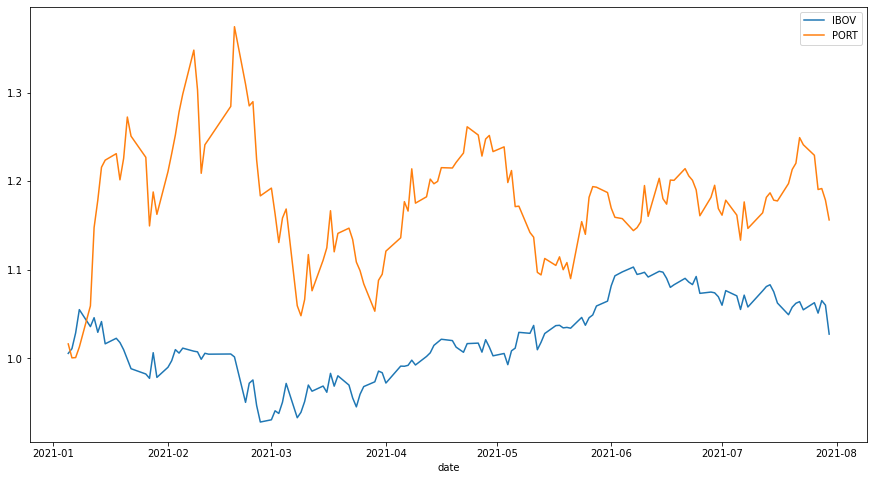

In [64]:
plot_df.cumsum().apply(np.exp).plot(figsize=(15,8))